In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from keras.models import load_model
from keras.callbacks import EarlyStopping
from h5py._hl.dataset import sel2

2023-11-16 10:23:43.911588: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 10:23:44.497243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 10:23:44.497337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 10:23:44.500893: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 10:23:44.784508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 10:23:44.787076: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [84]:
#Functions

def data_to_Input(data):
        
    data_3d = np.array([])
    data_3d = data[np.newaxis,:,:]
    data_3d = data_3d.transpose((1,2,0))
    
    return data_3d

def BP_dat_plot(dat, title):
    dist_data_sbp = dat[:, 0]
    dist_data_dbp = dat[:, 1]

    sbp_mean = np.mean(dist_data_sbp)
    dist_data_sbp = dist_data_sbp.astype(int)

    dbp_mean = np.mean(dist_data_dbp)
    dist_data_dbp = dist_data_dbp.astype(int)

    sbp_std = np.std(dat[:, 0])
    dbp_std = np.std(dat[:, 1])

    fig_bp_dist, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

    axs[0].hist(dist_data_sbp, bins=range(min(dist_data_sbp), max(dist_data_sbp)+2))
    axs[0].set_title(title + ' SBP')
    axs[0].axvline(x=sbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=sbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=sbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlabel('SBP value [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(sbp_mean, sbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(dist_data_dbp, bins=range(min(dist_data_dbp), max(dist_data_dbp)+2))
    axs[1].set_title(title + ' DBP')
    axs[1].axvline(x=dbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=dbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=dbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlabel('DBP value [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(dbp_mean, dbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  
  # absolute error
def error_plot(y_test, y_pred):

    y_test_2d = y_test[:,:,0]
    abs_error_sbp = y_test_2d.T[:,0] - y_pred[:,0]
    abs_error_dbp = y_test_2d.T[:,1] - y_pred[:,1]

    aberr_mean_sbp = np.mean(abs_error_sbp)
    aberr_mean_dbp = np.mean(abs_error_dbp)

    aberr_std_sbp = np.std(abs_error_sbp)
    aberr_std_dbp = np.std(abs_error_dbp)

    abs_error_sbp_int = abs_error_sbp.astype(int)
    abs_error_dbp_int = abs_error_dbp.astype(int)

    fig_abs_error, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)

    axs[0].hist(abs_error_sbp_int, bins=range(min(abs_error_sbp_int), max(abs_error_sbp_int)+2))
    axs[0].set_title('BP-CRNN-50 SBP Error')
    axs[0].axvline(x=aberr_mean_sbp, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=aberr_mean_sbp - aberr_std_sbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=aberr_mean_sbp + aberr_std_sbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlim([-10, 60])
    axs[0].set_xlabel('error [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.2fmmHg\nStd: %0.2fmmHg'%(aberr_mean_sbp, aberr_std_sbp), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(abs_error_dbp_int, bins=range(min(abs_error_dbp_int), max(abs_error_dbp_int)+2))
    axs[1].set_title('BP-CRNN-50 DBP Error')
    axs[1].axvline(x=aberr_mean_dbp, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=aberr_mean_dbp - aberr_std_dbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=aberr_mean_dbp + aberr_std_dbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlim([-20, 20])
    axs[1].set_xlabel('error [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.2fmmHg\nStd: %0.2fmmHg'%(aberr_mean_dbp, aberr_std_dbp), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  

def bland_altman_plot(data1, data2, *args, **kwargs):
    """
    Bland-Altman plot to compare two sets of measurements.

    Parameters
    ----------
    data1 : array_like
        The first set of measurements.
    data2 : array_like
        The second set of measurements.
    args : positional arguments
        Additional positional arguments to be passed to plt.scatter().
    kwargs : keyword arguments
        Additional keyword arguments to be passed to plt.scatter().

    Returns
    -------
    fig, ax : tuple
        The matplotlib figure and axes objects.
    """
    data1 = data1.T
    data2 = data2.T

    mean = np.mean([data1, data2], axis=0)
    diff = (data1 - data2)
    md = np.mean(diff, axis=1)
    sd = np.std(diff, axis=1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)

    ax[0].scatter(mean[0], diff[0], *args, **kwargs, alpha = 0.5)
    ax[0].axhline(md[0], color='gray', linestyle='--')
    ax[0].axhline(md[0] + 1.96*sd[0], color='red', linestyle='--')
    ax[0].axhline(md[0] - 1.96*sd[0], color='red', linestyle='--')
    ax[0].set_xlim([data1[0].min(), data1[0].max()])
    ax[0].set_ylim([-50, 50])
    ax[0].set_xlabel('Mean')
    ax[0].set_ylabel('Difference')
    ax[0].set_title('SBP Bland-Altman Plot')

    ax[1].scatter(mean[1], diff[1], *args, **kwargs, alpha = 0.5)
    ax[1].axhline(md[1], color='gray', linestyle='--')
    ax[1].axhline(md[1] + 1.96*sd[1], color='red', linestyle='--')
    ax[1].axhline(md[1] - 1.96*sd[1], color='red', linestyle='--')
    ax[1].set_xlim([data1[1].min(), data1[1].max()])
    ax[1].set_ylim([-50,50])
    ax[1].set_xlabel('Mean')
    ax[1].set_ylabel('Difference')
    ax[1].set_title('DBP Bland-Altman Plot')

    return fig, ax

def double_bland_altman_plot(data1, data2, data3, *args, **kwargs):
    
    data1 = data1.T
    data2 = data2.T
    data3 = data3.T

    mean_1 = np.mean([data1, data2], axis=0)
    diff_1 = (data1 - data2)
    md_1 = np.mean(diff_1, axis=1)
    sd_1 = np.std(diff_1, axis=1)
    
    mean_2 = np.mean([data1, data3], axis=0)
    diff_2 = (data1 - data3)
    md_2 = np.mean(diff_2, axis=1)
    sd_2 = np.std(diff_2, axis=1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 10), tight_layout=False)

    ax[0].scatter(mean_1[0], diff_1[0], color='red', *args, **kwargs, alpha = 0.5)
    ax[0].scatter(mean_2[0], diff_2[0], color='blue', *args, **kwargs, alpha = 0.5)
    ax[0].axhline(md_1[0], color='gray', linestyle='--')
    ax[0].axhline(md_1[0] + 1.96*sd_1[0], color='darkred', linestyle='--')
    ax[0].axhline(md_1[0] - 1.96*sd_1[0], color='darkred', linestyle='--')
    
    ax[0].axhline(md_2[0], color='black', linestyle='--')
    ax[0].axhline(md_2[0] + 1.96*sd_2[0], color='darkblue', linestyle='--')
    ax[0].axhline(md_2[0] - 1.96*sd_2[0], color='darkblue', linestyle='--')
    ax[0].set_xlim([data1[0].min(), data1[0].max()])
    
    ax[0].set_ylim([-35, 35])
    ax[0].set_xlabel('Mean')
    ax[0].set_ylabel('Difference')
    ax[0].set_title('SBP Bland-Altman Plot')

    ax[1].scatter(mean_1[1], diff_1[1], color='red', *args, **kwargs, alpha = 0.5)
    ax[1].scatter(mean_2[1], diff_2[1], color='blue', *args, **kwargs, alpha = 0.5)
    ax[1].axhline(md_1[1], color='gray', linestyle='--')
    ax[1].axhline(md_1[1] + 1.96*sd_1[1], color='darkred', linestyle='--')
    ax[1].axhline(md_1[1] - 1.96*sd_1[1], color='darkred', linestyle='--')
    ax[1].axhline(md_2[1], color='black', linestyle='--')
    ax[1].axhline(md_2[1] + 1.96*sd_2[1], color='darkblue', linestyle='--')
    ax[1].axhline(md_2[1] - 1.96*sd_2[1], color='darkblue', linestyle='--')
    ax[1].set_xlim([data1[1].min(), data1[1].max()])
    ax[1].set_ylim([-35,35])
    ax[1].set_xlabel('Mean')
    ax[1].set_ylabel('Difference')
    ax[1].set_title('DBP Bland-Altman Plot')

    return fig, ax

def pred_plot(test_dat, pred_dat):
    
    sbp_min = test_dat[:, 0].min()
    sbp_max = test_dat[:, 0].max()
    dbp_min = test_dat[:, 1].min()
    dbp_max = test_dat[:, 1].max()
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)
    
    ax[0].scatter(test_dat[:,0], pred_dat[:,0], c='red', alpha = 0.5)
    ax[0].set_xlim([sbp_min-10, sbp_max+10])
    ax[0].set_ylim([sbp_min-10, sbp_max+10])
    ax[0].set_xlabel('True SBP')
    ax[0].set_ylabel('Estimated SBP')
    ax[0].set_title('SBP')
    
    ax[1].scatter(test_dat[:,1], pred_dat[:,1], c='red', alpha = 0.5)
    ax[1].set_xlim([dbp_min-10, dbp_max+10])
    ax[1].set_ylim([dbp_min-10, dbp_max+10])
    ax[1].set_xlabel('True DBP')
    ax[1].set_ylabel('Estimated DBP')
    ax[1].set_title('DBP')
    
    return fig, ax

def Result_calculator(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        SBP_val = float(lines[1][12:-1])
        DBP_val = float(lines[2][12:-1])
        SBP_PR_val = float(lines[3][-4:-1])
        DBP_PR_val = float(lines[4][-4:-1])
        
        return [SBP_val, DBP_val, SBP_PR_val, DBP_PR_val]

Type dataset root:  D:\김윤철\Dataset\Ex_3\Vitaldb_dataset\Preprocessed\Group_1
Type train size per person:  720


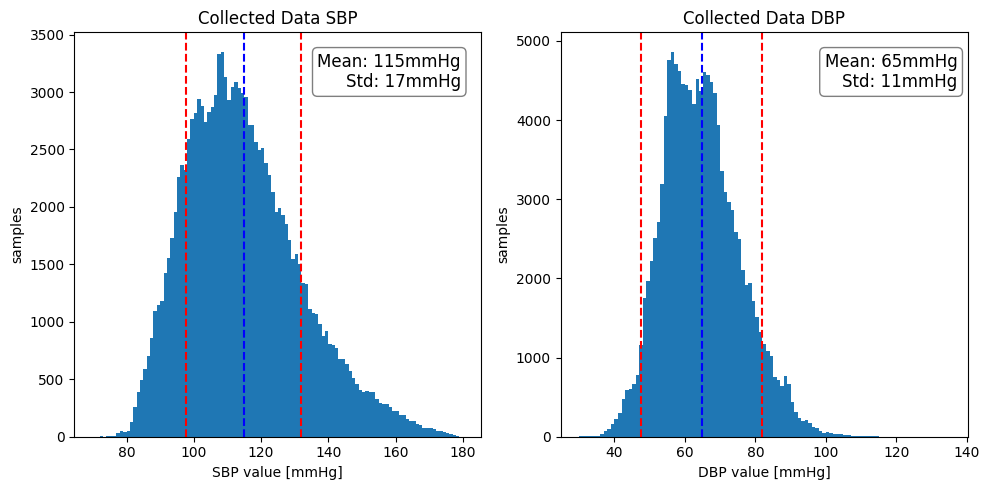

In [4]:
#Train data 부르기
processed_data_dir = input("Type dataset root: ")
train_data_size = int(input("Type train size per person: "))*5/4

total_num = 0
file_list = os.listdir(processed_data_dir)
x_data, y_data = np.empty((0,125)), np.empty((0,2))
for file_name in file_list:
    if file_name.endswith('.npz'):
        data = np.load(processed_data_dir+"//"+file_name)
        x_data = np.concatenate((x_data, data['x']),axis=0)
        y_data = np.concatenate((y_data, data['y']),axis=0)
        total_num += 1
        
x_data = data_to_Input(x_data)        
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size = train_data_size*total_num/x_data.shape[0], test_size = 720*total_num/x_data.shape[0])
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8, test_size = 0.2)

BP_dat_plot(y_data, "Collected Data") 

In [18]:
input_shape = (125, 1)

input = tf.keras.Input(shape = input_shape)
# Batch Normalization for each layers

x1 = tf.keras.layers.Conv1D(filters = 50, kernel_size=7, activation='relu', padding='same')(input)

x2 = tf.keras.layers.BatchNormalization()(x1)
x2 = tf.keras.layers.Conv1D(filters = 50, kernel_size=7, activation='relu', padding='same')(x2)

x3 = tf.keras.layers.BatchNormalization()(x2)
x3 = tf.keras.layers.Conv1D(filters = 50, kernel_size=7, activation='relu', padding='same')(x3)

concat = tf.keras.layers.Concatenate(axis = 2)([x1, x3])

x4 = tf.keras.layers.BatchNormalization()(concat)
x4 = tf.keras.layers.GRU(25, return_sequences=True, activation='tanh')(x4)
x4 = tf.keras.layers.Flatten()(x4)

x4 = tf.keras.layers.BatchNormalization()(x4)
x4 = tf.keras.layers.Dense(units=64, activation='relu')(x4)

x4 = tf.keras.layers.BatchNormalization()(x4)
x4 = tf.keras.layers.Dense(units=2, activation='relu')(x4)

output = x4

BP_CRNN_Model = tf.keras.Model(inputs = input, outputs = output)

# fit
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
BP_CRNN_Model.compile(opt, loss='mean_squared_error', metrics = ['mae'])
BP_CRNN_Model.reset_states() #가중치 초기화
callback = EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True)
hist = BP_CRNN_Model.fit(x_train, y_train, epochs = 1000, batch_size=64, verbose = 2, validation_data = (x_val, y_val), callbacks=[callback])

Epoch 1/1000
563/563 - 19s - loss: 6246.7363 - mae: 72.6539 - val_loss: 3892.3987 - val_mae: 50.9643 - 19s/epoch - 33ms/step
Epoch 2/1000
563/563 - 15s - loss: 3354.0002 - mae: 48.1383 - val_loss: 2465.0044 - val_mae: 40.4423 - 15s/epoch - 27ms/step
Epoch 3/1000
563/563 - 15s - loss: 1399.1421 - mae: 28.2795 - val_loss: 692.7053 - val_mae: 22.2776 - 15s/epoch - 26ms/step
Epoch 4/1000
563/563 - 15s - loss: 193.8283 - mae: 10.0072 - val_loss: 112.6944 - val_mae: 8.0893 - 15s/epoch - 27ms/step
Epoch 5/1000
563/563 - 15s - loss: 109.9970 - mae: 7.9815 - val_loss: 109.2181 - val_mae: 7.9388 - 15s/epoch - 26ms/step
Epoch 6/1000
563/563 - 15s - loss: 103.5082 - mae: 7.7060 - val_loss: 105.1092 - val_mae: 7.8138 - 15s/epoch - 26ms/step
Epoch 7/1000
563/563 - 15s - loss: 96.8246 - mae: 7.4253 - val_loss: 110.7084 - val_mae: 8.0570 - 15s/epoch - 26ms/step
Epoch 8/1000
563/563 - 15s - loss: 90.8717 - mae: 7.1695 - val_loss: 91.5216 - val_mae: 7.1826 - 15s/epoch - 26ms/step
Epoch 9/1000
563/563 - 

In [14]:
# model 저장 (300번 학습)
save_folder_path = input("Type save folder path: ") + "//"
model_name = input("Type model name: ") + ".h5"
BP_CRNN_Model.save(save_folder_path + model_name)

TypeError: 'KerasTensor' object is not callable

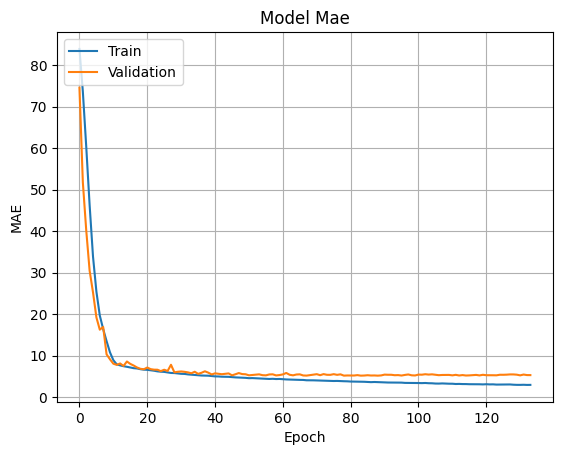

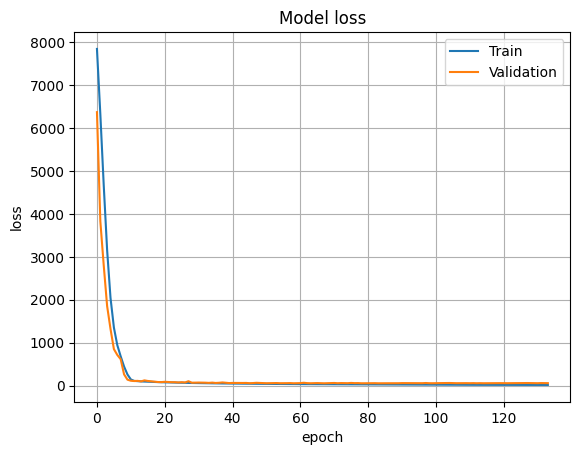

In [7]:
# 학습 기록
plt.plot(hist.history["mae"])
plt.plot(hist.history["val_mae"])
plt.title('Model Mae')
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.grid()
plt.show()

1125/1125 [==============================] - 6s 5ms/step
MAE for SBP: 5.08
MAE for DBP: 2.87


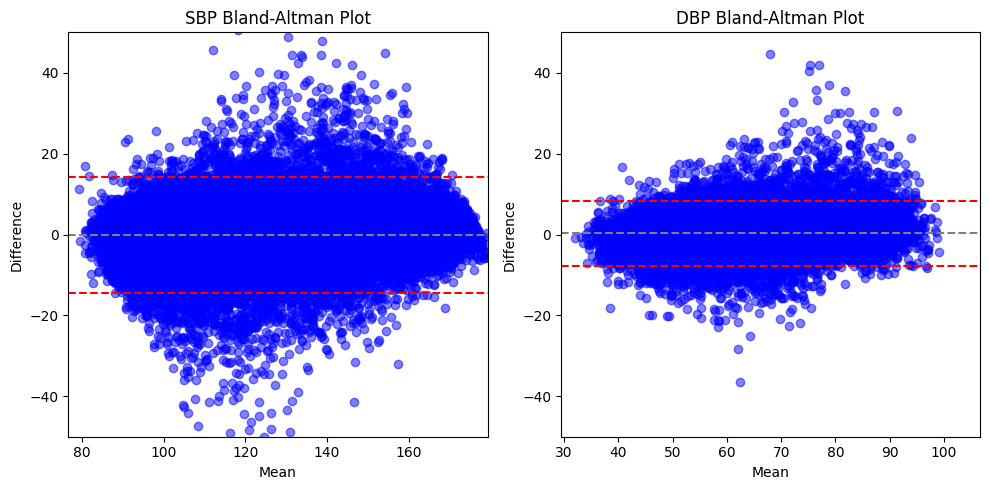

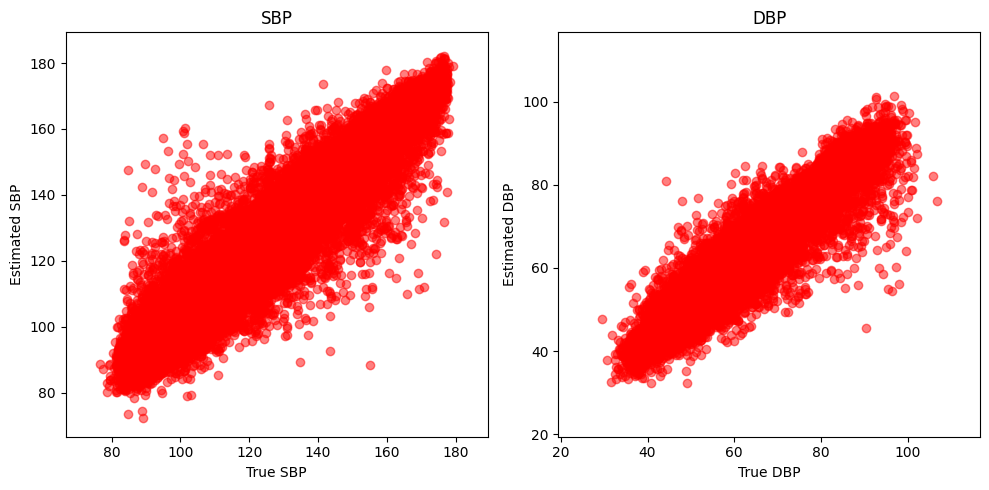

In [7]:
# Predict on test set
y_pred = BP_CRNN_Model.predict(x_test)

print("MAE for SBP: {:.2f}".format(mean_absolute_error(y_test[:,0], y_pred[:,0])))
print("MAE for DBP: {:.2f}".format(mean_absolute_error(y_test[:,1], y_pred[:,1])))

fig_ba, ax_ba = bland_altman_plot(y_test, y_pred, color='blue', marker='o')
fig_ac, ax_ac = pred_plot(y_test, y_pred)

In [8]:
# 재학습을 위해 선행했던 학습모델 불러오기

model = load_model('50_5h_Trained.h5')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss='mean_squared_error', metrics = ['mae'])
callback = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

OSError: No file or directory found at 50_5h_Trained.h5

Text(0.5, 0, 'samples')

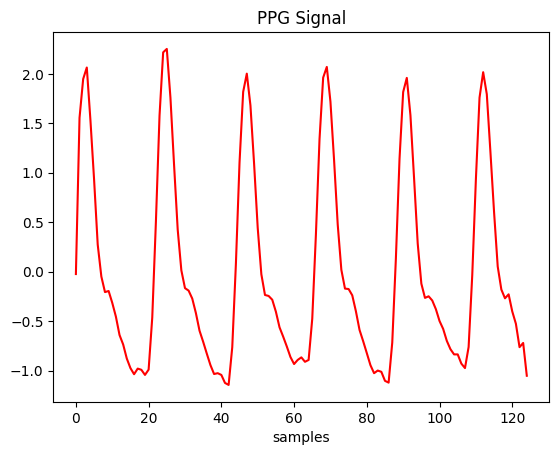

In [74]:
# 수집한 ppg 데이터 시각화

plt.plot(x_train[119, :, 0], color='red')
plt.title("PPG Signal")
plt.xlabel("samples")

In [3]:
directory_path = input("Type models folder path: ")

res_MtoM_50 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR
res_MtoM_100 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR
res_MtoM_360 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR

res_VtoV_50 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR
res_VtoV_100 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR
res_VtoV_360 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR

res_MtoV_50 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR
res_MtoV_100 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR
res_MtoV_360 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR

res_VtoM_50 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR
res_VtoM_100 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR
res_VtoM_360 = np.empty((0,4), dtype = float) #SBP_MAE, DBP_MAE, SBP_PR, DBP_PR

for root, dirs, files in os.walk(directory_path):
    for file in files:
        file_path = os.path.join(root, file)
        if root[-3] =='M' and root[-15]=='M':
            if file.startswith("Collective Result"):  # Check if the file has a .txt extension
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    if lines[0][-8] == '5':
                        res_MtoM_50 = np.insert(res_MtoM_50, res_MtoM_50.shape[0], Result_calculator(file_path), axis = 0)
                    if lines[0][-8] == '0':
                        res_MtoM_100 = np.insert(res_MtoM_100, res_MtoM_100.shape[0], Result_calculator(file_path), axis = 0)
                    if lines[0][-8] == '6':
                        res_MtoM_360 = np.insert(res_MtoM_360, res_MtoM_360.shape[0], Result_calculator(file_path), axis = 0)
                        
        if root[-3] =='V' and root[-15]=='V':
            if file.startswith("Collective Result"):  # Check if the file has a .txt extension
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    if lines[0][-8] == '5':
                        res_VtoV_50 = np.insert(res_VtoV_50, res_VtoV_50.shape[0], Result_calculator(file_path), axis = 0)
                    if lines[0][-8] == '0':
                        res_VtoV_100 = np.insert(res_VtoV_100, res_VtoV_100.shape[0], Result_calculator(file_path), axis = 0)
                    if lines[0][-8] == '6':
                        res_VtoV_360 = np.insert(res_VtoV_360, res_VtoV_360.shape[0], Result_calculator(file_path), axis = 0)
                        
        if root[-15] == 'M' and root[-3] =='V':  
            if file.startswith("Collective Result"):  # Check if the file has a .txt extension
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    if lines[0][-8] == '5':
                        res_MtoV_50 = np.insert(res_MtoV_50, res_MtoV_50.shape[0], Result_calculator(file_path), axis = 0)
                    if lines[0][-8] == '0':
                        res_MtoV_100 = np.insert(res_MtoV_100, res_MtoV_100.shape[0], Result_calculator(file_path), axis = 0)
                    if lines[0][-8] == '6':
                        res_MtoV_360 = np.insert(res_MtoV_360, res_MtoV_360.shape[0], Result_calculator(file_path), axis = 0)
                        
        if root[-15] == 'V' and root[-3] =='M': 
            if file.startswith("Collective Result"):  # Check if the file has a .txt extension
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    if lines[0][-8] == '5':
                        res_VtoM_50 = np.insert(res_VtoM_50, res_VtoM_50.shape[0], Result_calculator(file_path), axis = 0)
                    if lines[0][-8] == '0':
                        res_VtoM_100 = np.insert(res_VtoM_100, res_VtoM_100.shape[0], Result_calculator(file_path), axis = 0)
                    if lines[0][-8] == '6':
                        res_VtoM_360 = np.insert(res_VtoM_360, res_VtoM_360.shape[0], Result_calculator(file_path), axis = 0)
                        
# M to M Mean
MtoM_50_mean = np.mean(res_MtoM_50, axis = 0)
MtoM_100_mean = np.mean(res_MtoM_100, axis = 0)
MtoM_360_mean = np.mean(res_MtoM_360, axis = 0)
# V to V Mean
VtoV_50_mean = np.mean(res_VtoV_50, axis = 0)
VtoV_100_mean = np.mean(res_VtoV_100, axis = 0)
VtoV_360_mean = np.mean(res_VtoV_360, axis = 0)
# M to V Mean
MtoV_50_mean = np.mean(res_MtoV_50, axis = 0)
MtoV_100_mean = np.mean(res_MtoV_100, axis = 0)
MtoV_360_mean = np.mean(res_MtoV_360, axis = 0)
# V to M Mean
VtoM_50_mean = np.mean(res_VtoM_50, axis = 0)
VtoM_100_mean = np.mean(res_VtoM_100, axis = 0)
VtoM_360_mean = np.mean(res_VtoM_360, axis = 0)

Type models folder path:  /home/yoonchul/GoogleDrive/lab/research/ppg_nibp/Models/Ex_3


Text(0, 0.5, 'MAE(mmHg)')

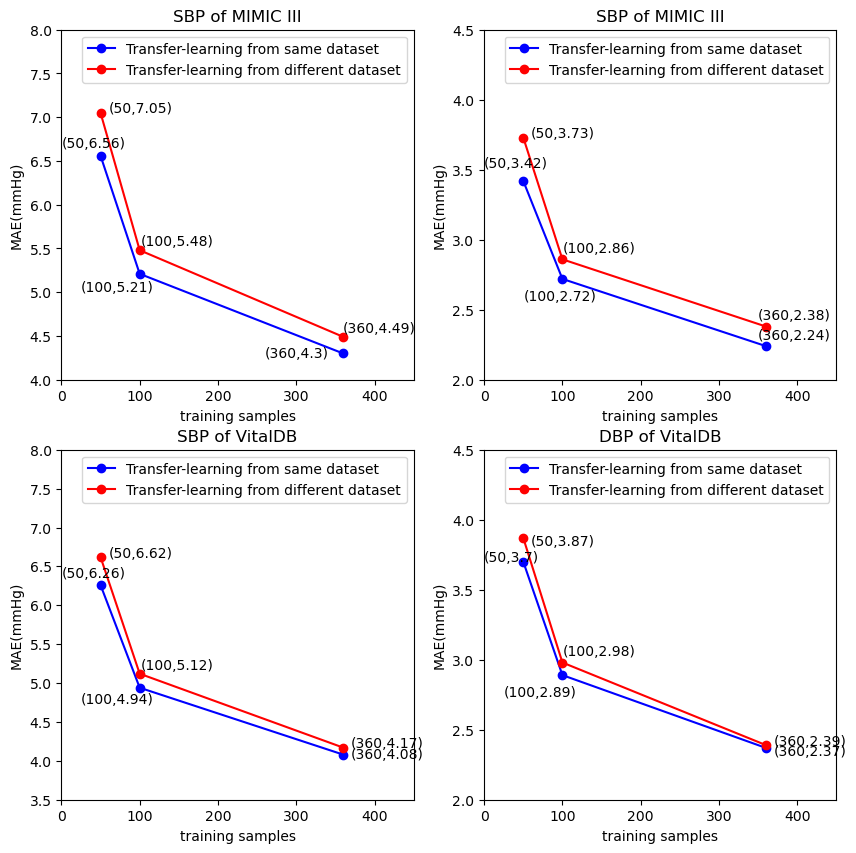

In [56]:
x_1 = [50, 100, 360]
x_2 = [50, 100, 360]
y_1 = [np.round(MtoM_50_mean[0], 2), np.round(MtoM_100_mean[0],2), np.round(MtoM_360_mean[0], 2)]
y_2 = [np.round(VtoM_50_mean[0], 2), np.round(VtoM_100_mean[0], 2), np.round(VtoM_360_mean[0], 2)]

fig, ax = plt.subplots(2, 2, figsize = (10,10))

ax[0, 0].plot(x_1, y_1, color='blue', label = 'Transfer-learning from same dataset', marker = ".",  markersize=12)
ax[0, 0].plot(x_2, y_2, color='red', label = 'Transfer-learning from different dataset', marker = ".",  markersize=12)
ax[0, 0].set_xlim(0, 450)
ax[0, 0].set_ylim(4, 8)
ax[0, 0].legend()
ax[0, 0].annotate('('+str(x_1[0])+','+str(y_1[0])+')', xy=(x_1[0], y_1[0]), xytext=(x_1[0]-50, y_1[0]+0.1))
ax[0, 0].annotate('('+str(x_1[1])+','+str(y_1[1])+')', xy=(x_1[1], y_1[1]), xytext=(x_1[1]-75, y_1[1]-0.2))
ax[0, 0].annotate('('+str(x_1[-1])+','+str(y_1[-1])+')', xy=(x_1[-1], y_1[-1]), xytext=(x_1[-1]-100, y_1[-1]-0.05))

ax[0, 0].annotate('('+str(x_2[0])+','+str(y_2[0])+')', xy=(x_2[0], y_2[0]), xytext=(x_2[0]+10, y_2[0]))
ax[0, 0].annotate('('+str(x_2[1])+','+str(y_2[1])+')', xy=(x_2[1], y_2[1]), xytext=(x_2[1]+1, y_2[1]+0.05))
ax[0, 0].annotate('('+str(x_2[-1])+','+str(y_2[-1])+')', xy=(x_2[-1], y_2[-1]), xytext=(x_2[-1], y_2[-1]+0.05))

ax[0, 0].set_title("SBP of MIMIC III")
ax[0, 0].set_xlabel("training samples")
ax[0, 0].set_ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)
y_3 = [np.round(MtoM_50_mean[1], 2), np.round(MtoM_100_mean[1],2), np.round(MtoM_360_mean[1], 2)]
y_4 = [np.round(VtoM_50_mean[1], 2), np.round(VtoM_100_mean[1], 2), np.round(VtoM_360_mean[1], 2)]

ax[0,1].plot(x_1, y_3, color='blue', label = 'Transfer-learning from same dataset', marker = ".",  markersize=12)
ax[0,1].plot(x_2, y_4, color='red', label = 'Transfer-learning from different dataset', marker = ".",  markersize=12)
ax[0,1].set_xlim(0, 450)
ax[0,1].set_ylim(2, 4.5)
ax[0,1].legend()
ax[0,1].annotate('('+str(x_1[0])+','+str(y_3[0])+')', xy=(x_1[0], y_3[0]), xytext=(x_1[0]-50, y_3[0]+0.1))
ax[0,1].annotate('('+str(x_1[1])+','+str(y_3[1])+')', xy=(x_1[1], y_3[1]), xytext=(x_1[1]-50, y_3[1]-0.15))
ax[0,1].annotate('('+str(x_1[-1])+','+str(y_3[-1])+')', xy=(x_1[-1], y_3[-1]), xytext=(x_1[-1]-10, y_3[-1]+0.05))

ax[0,1].annotate('('+str(x_2[0])+','+str(y_4[0])+')', xy=(x_2[0], y_4[0]), xytext=(x_2[0]+10, y_4[0]))
ax[0,1].annotate('('+str(x_2[1])+','+str(y_4[1])+')', xy=(x_2[1], y_4[1]), xytext=(x_2[1]+1, y_4[1]+0.05))
ax[0,1].annotate('('+str(x_2[-1])+','+str(y_4[-1])+')', xy=(x_2[-1], y_4[-1]), xytext=(x_2[-1]-10, y_4[-1]+0.05))

ax[0,1].set_title("SBP of MIMIC III")
ax[0,1].set_xlabel("training samples")
ax[0,1].set_ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)

y_5 = [np.round(VtoV_50_mean[0], 2), np.round(VtoV_100_mean[0],2), np.round(VtoV_360_mean[0], 2)] #Transfered from same dataset model
y_6 = [np.round(MtoV_50_mean[0], 2), np.round(MtoV_100_mean[0], 2), np.round(MtoV_360_mean[0], 2)]

ax[1,0].plot(x_1, y_5, color='blue', label = 'Transfer-learning from same dataset', marker = ".",  markersize=12)
ax[1,0].plot(x_2, y_6, color='red', label = 'Transfer-learning from different dataset', marker = ".",  markersize=12)
ax[1,0].set_xlim(0, 450)
ax[1,0].set_ylim(3.5, 8)
ax[1,0].legend()
ax[1,0].annotate('('+str(x_1[0])+','+str(y_5[0])+')', xy=(x_1[0], y_5[0]), xytext=(x_1[0]-50, y_5[0]+0.1))
ax[1,0].annotate('('+str(x_1[1])+','+str(y_5[1])+')', xy=(x_1[1], y_5[1]), xytext=(x_1[1]-75, y_5[1]-0.2))
ax[1,0].annotate('('+str(x_1[-1])+','+str(y_5[-1])+')', xy=(x_1[-1], y_5[-1]), xytext=(x_1[-1]+10, y_5[-1]-0.05))

ax[1,0].annotate('('+str(x_2[0])+','+str(y_6[0])+')', xy=(x_2[0], y_6[0]), xytext=(x_2[0]+10, y_6[0]))
ax[1,0].annotate('('+str(x_2[1])+','+str(y_6[1])+')', xy=(x_2[1], y_6[1]), xytext=(x_2[1]+1, y_6[1]+0.05))
ax[1,0].annotate('('+str(x_2[-1])+','+str(y_6[-1])+')', xy=(x_2[-1], y_6[-1]), xytext=(x_2[-1]+10, y_6[-1]))

ax[1,0].set_title("SBP of VitalDB")
ax[1,0].set_xlabel("training samples")
ax[1,0].set_ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)

y_7 = [np.round(VtoV_50_mean[1], 2), np.round(VtoV_100_mean[1],2), np.round(VtoV_360_mean[1], 2)] #Transfered from same dataset model
y_8 = [np.round(MtoV_50_mean[1], 2), np.round(MtoV_100_mean[1], 2), np.round(MtoV_360_mean[1], 2)]

ax[1,1].plot(x_1, y_7, color='blue', label = 'Transfer-learning from same dataset', marker = ".",  markersize=12)
ax[1,1].plot(x_2, y_8, color='red', label = 'Transfer-learning from different dataset', marker = ".",  markersize=12)
ax[1,1].set_xlim(0, 450)
ax[1,1].set_ylim(2, 4.5)
ax[1,1].legend()
ax[1,1].annotate('('+str(x_1[0])+','+str(y_7[0])+')', xy=(x_1[0], y_7[0]), xytext=(x_1[0]-50, y_7[0]))
ax[1,1].annotate('('+str(x_1[1])+','+str(y_7[1])+')', xy=(x_1[1], y_7[1]), xytext=(x_1[1]-75, y_7[1]-0.15))
ax[1,1].annotate('('+str(x_1[-1])+','+str(y_7[-1])+')', xy=(x_1[-1], y_7[-1]), xytext=(x_1[-1]+10, y_7[-1]-0.05))

ax[1,1].annotate('('+str(x_2[0])+','+str(y_8[0])+')', xy=(x_2[0], y_8[0]), xytext=(x_2[0]+10, y_8[0]-0.05))
ax[1,1].annotate('('+str(x_2[1])+','+str(y_8[1])+')', xy=(x_2[1], y_8[1]), xytext=(x_2[1]+1, y_8[1]+0.05))
ax[1,1].annotate('('+str(x_2[-1])+','+str(y_8[-1])+')', xy=(x_2[-1], y_8[-1]), xytext=(x_2[-1]+10, y_8[-1]))

ax[1,1].set_title("DBP of VitalDB")
ax[1,1].set_xlabel("training samples")
ax[1,1].set_ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)

In [ ]:
/home/yoonchul/GoogleDrive/lab/research/ppg_nibp/dataset/ex_3/Vitaldb_dataset/Group_1/processed_Vitaldb_p0119.npz
/home/yoonchul/GoogleDrive/lab/research/ppg_nibp/Models/Ex_3/V1H50PG2_to_VG1/0119/50/0119._50.0TL_model.h5
/home/yoonchul/GoogleDrive/lab/research/ppg_nibp/Models/Ex_3/M1H50PG1_to_VG1/0119/50/0119._50.0TL_model.h5

In [70]:
# Example difference between difference pre-trained model
data_path = input("Type Data path: ")
data = np.load(data_path)
x_data = data['x']
y_data = data['y']

_, x_test, _, y_test = train_test_split(x_data, y_data, test_size = 720/x_data.shape[0])

VV_model_path = input("Type V to V model path: ")
MV_model_path = input("Type M to V model path: ")

VV_model = load_model(VV_model_path)
MV_model = load_model(MV_model_path)

VV_pred = VV_model.predict(x_test)
MV_pred = MV_model.predict(x_test)

print("MAE for SBP: {:.2f}".format(mean_absolute_error(y_test[:,0], VV_pred[:,0])))
print("MAE for DBP: {:.2f}".format(mean_absolute_error(y_test[:,1], VV_pred[:,1])))

print("MAE for SBP: {:.2f}".format(mean_absolute_error(y_test[:,0], MV_pred[:,0])))
print("MAE for DBP: {:.2f}".format(mean_absolute_error(y_test[:,1], MV_pred[:,1])))



Type Data path:  /home/yoonchul/GoogleDrive/lab/research/ppg_nibp/dataset/ex_3/Vitaldb_dataset/Group_1/processed_Vitaldb_p0119.npz
Type V to V model path:  /home/yoonchul/GoogleDrive/lab/research/ppg_nibp/Models/Ex_3/V1H50PG2_to_VG1/0119/50/0119._50.0TL_model.h5
Type M to V model path:  /home/yoonchul/GoogleDrive/lab/research/ppg_nibp/Models/Ex_3/M1H50PG1_to_VG1/0119/50/0119._50.0TL_model.h5


23/23 [==============================] - 1s 12ms/step
MAE for SBP: 4.68
MAE for DBP: 3.23
MAE for SBP: 4.45
MAE for DBP: 2.61


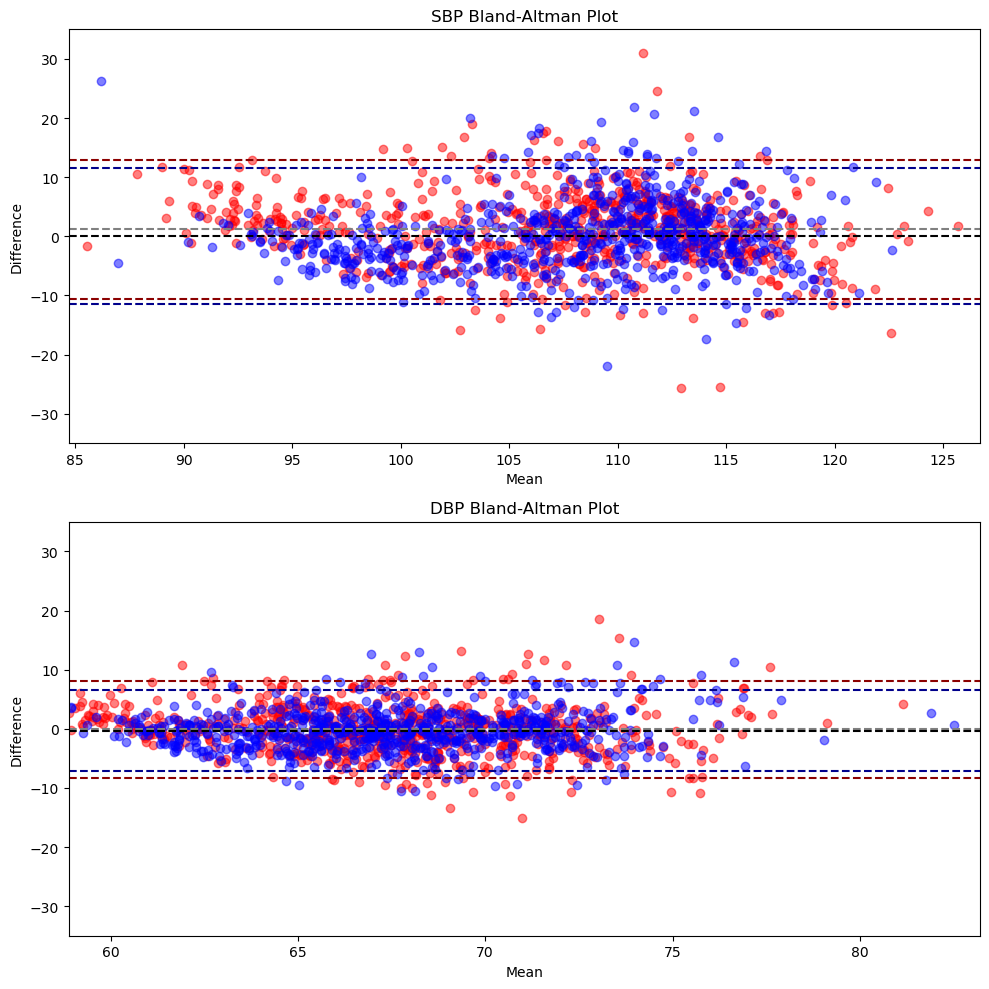

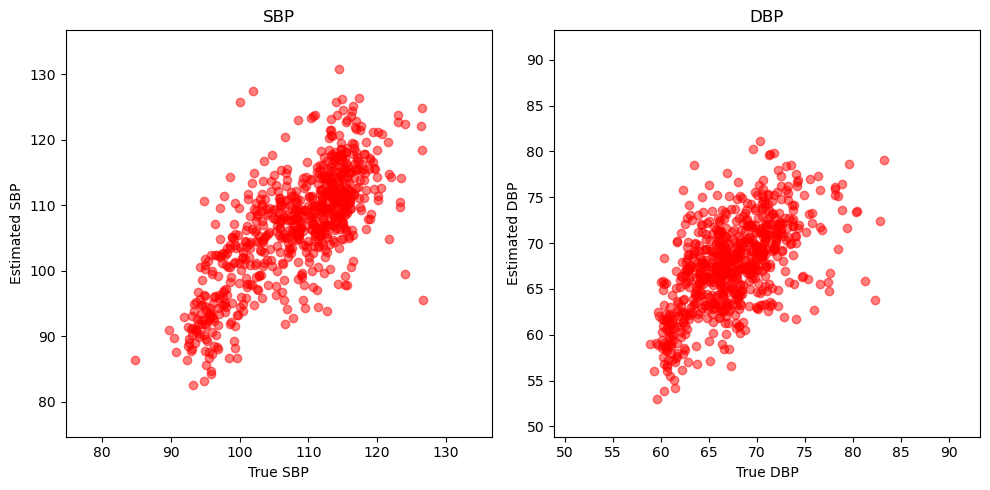

In [85]:
fig_ba, ax_ba = double_bland_altman_plot(y_test, VV_pred, MV_pred, marker='o')
fig_ac, ax_ac = pred_plot(y_test, VV_pred)

Text(0, 0.5, 'MAE(mmHg)')

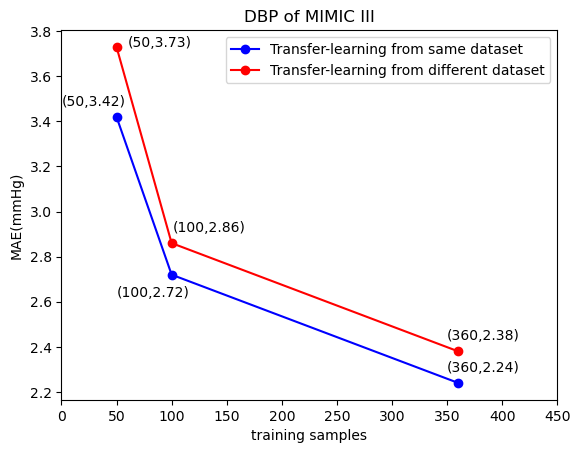

In [6]:
x_1 = [50, 100, 360]
x_2 = [50, 100, 360]
y_1 = [np.round(MtoM_50_mean[1], 2), np.round(MtoM_100_mean[1],2), np.round(MtoM_360_mean[1], 2)]
y_2 = [np.round(VtoM_50_mean[1], 2), np.round(VtoM_100_mean[1], 2), np.round(VtoM_360_mean[1], 2)]

plt.plot(x_1, y_1, color='blue', label = 'Transfer-learning from same dataset', marker = ".",  markersize=12)
plt.plot(x_2, y_2, color='red', label = 'Transfer-learning from different dataset', marker = ".",  markersize=12)
plt.xlim(0, 450)
plt.legend()
plt.annotate('('+str(x_1[0])+','+str(y_1[0])+')', xy=(x_1[0], y_1[0]), xytext=(x_1[0]-50, y_1[0]+0.05))
plt.annotate('('+str(x_1[1])+','+str(y_1[1])+')', xy=(x_1[1], y_1[1]), xytext=(x_1[1]-50, y_1[1]-0.1))
plt.annotate('('+str(x_1[-1])+','+str(y_1[-1])+')', xy=(x_1[-1], y_1[-1]), xytext=(x_1[-1]-10, y_1[-1]+0.05))

plt.annotate('('+str(x_2[0])+','+str(y_2[0])+')', xy=(x_2[0], y_2[0]), xytext=(x_2[0]+10, y_2[0]))
plt.annotate('('+str(x_2[1])+','+str(y_2[1])+')', xy=(x_2[1], y_2[1]), xytext=(x_2[1]+1, y_2[1]+0.05))
plt.annotate('('+str(x_2[-1])+','+str(y_2[-1])+')', xy=(x_2[-1], y_2[-1]), xytext=(x_2[-1]-10, y_2[-1]+0.05))

plt.title("DBP of MIMIC III")
plt.xlabel("training samples")
plt.ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)

Text(0, 0.5, 'MAE(mmHg)')

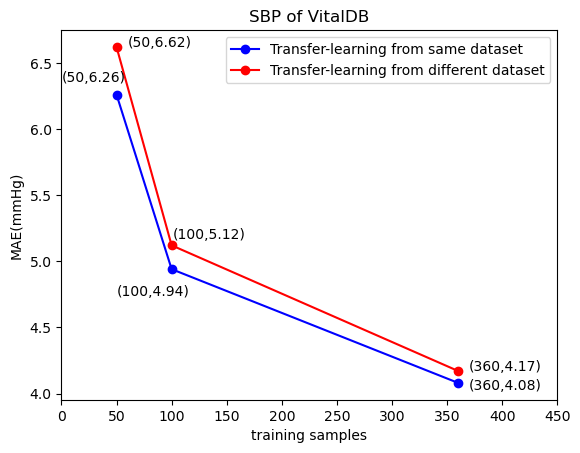

In [7]:
x_1 = [50, 100, 360]
x_2 = [50, 100, 360]
y_1 = [np.round(VtoV_50_mean[0], 2), np.round(VtoV_100_mean[0],2), np.round(VtoV_360_mean[0], 2)] #Transfered from same dataset model
y_2 = [np.round(MtoV_50_mean[0], 2), np.round(MtoV_100_mean[0], 2), np.round(MtoV_360_mean[0], 2)]

plt.plot(x_1, y_1, color='blue', label = 'Transfer-learning from same dataset', marker = ".",  markersize=12)
plt.plot(x_2, y_2, color='red', label = 'Transfer-learning from different dataset', marker = ".",  markersize=12)
plt.xlim(0, 450)
plt.legend()

plt.annotate('('+str(x_1[0])+','+str(y_1[0])+')', xy=(x_1[0], y_1[0]), xytext=(x_1[0]-50, y_1[0]+0.1))
plt.annotate('('+str(x_1[1])+','+str(y_1[1])+')', xy=(x_1[1], y_1[1]), xytext=(x_1[1]-50, y_1[1]-0.2))
plt.annotate('('+str(x_1[-1])+','+str(y_1[-1])+')', xy=(x_1[-1], y_1[-1]), xytext=(x_1[-1]+10, y_1[-1]-0.05))

plt.annotate('('+str(x_2[0])+','+str(y_2[0])+')', xy=(x_2[0], y_2[0]), xytext=(x_2[0]+10, y_2[0]))
plt.annotate('('+str(x_2[1])+','+str(y_2[1])+')', xy=(x_2[1], y_2[1]), xytext=(x_2[1]+1, y_2[1]+0.05))
plt.annotate('('+str(x_2[-1])+','+str(y_2[-1])+')', xy=(x_2[-1], y_2[-1]), xytext=(x_2[-1]+10, y_2[-1]))

plt.title("SBP of VitalDB")
plt.xlabel("training samples")
plt.ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)

Text(0, 0.5, 'MAE(mmHg)')

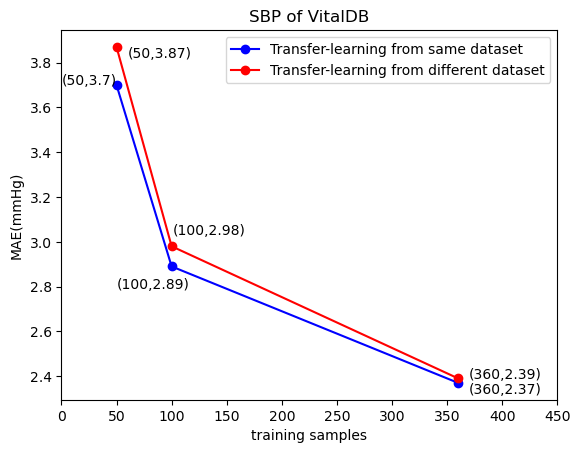

In [8]:
x_1 = [50, 100, 360]
x_2 = [50, 100, 360]
y_1 = [np.round(VtoV_50_mean[1], 2), np.round(VtoV_100_mean[1],2), np.round(VtoV_360_mean[1], 2)] #Transfered from same dataset model
y_2 = [np.round(MtoV_50_mean[1], 2), np.round(MtoV_100_mean[1], 2), np.round(MtoV_360_mean[1], 2)]

plt.plot(x_1, y_1, color='blue', label = 'Transfer-learning from same dataset', marker = ".",  markersize=12)
plt.plot(x_2, y_2, color='red', label = 'Transfer-learning from different dataset', marker = ".",  markersize=12)
plt.xlim(0, 450)
plt.legend()
plt.annotate('('+str(x_1[0])+','+str(y_1[0])+')', xy=(x_1[0], y_1[0]), xytext=(x_1[0]-50, y_1[0]))
plt.annotate('('+str(x_1[1])+','+str(y_1[1])+')', xy=(x_1[1], y_1[1]), xytext=(x_1[1]-50, y_1[1]-0.1))
plt.annotate('('+str(x_1[-1])+','+str(y_1[-1])+')', xy=(x_1[-1], y_1[-1]), xytext=(x_1[-1]+10, y_1[-1]-0.05))

plt.annotate('('+str(x_2[0])+','+str(y_2[0])+')', xy=(x_2[0], y_2[0]), xytext=(x_2[0]+10, y_2[0]-0.05))
plt.annotate('('+str(x_2[1])+','+str(y_2[1])+')', xy=(x_2[1], y_2[1]), xytext=(x_2[1]+1, y_2[1]+0.05))
plt.annotate('('+str(x_2[-1])+','+str(y_2[-1])+')', xy=(x_2[-1], y_2[-1]), xytext=(x_2[-1]+10, y_2[-1]))

plt.title("SBP of VitalDB")
plt.xlabel("training samples")
plt.ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)

Text(0, 0.5, 'MAE(mmHg)')

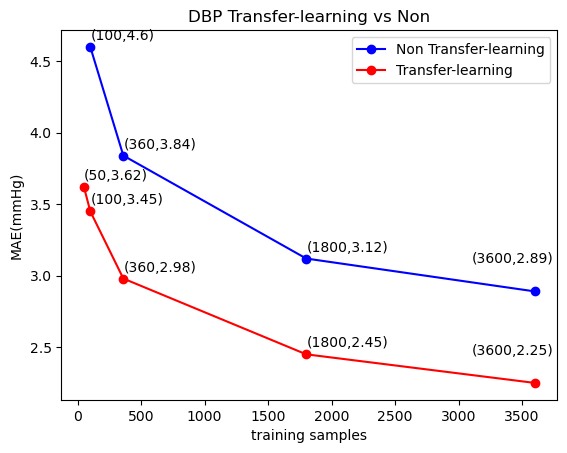

In [5]:
x_1 = [100, 360, 1800, 3600]
x_2 = [50, 100, 360, 1800, 3600]
y_1 = [4.6, 3.84, 3.12, 2.89]
y_2 = [3.62, 3.45, 2.98, 2.45, 2.25]

plt.plot(x_1, y_1, color='blue', label = 'Non Transfer-learning', marker = ".",  markersize=12)
plt.plot(x_2, y_2, color='red', label = 'Transfer-learning', marker = ".",  markersize=12)
plt.legend()
for i in range(len(x_1)-1):
    plt.annotate('('+str(x_1[i])+','+str(y_1[i])+')', xy=(x_1[i], y_1[i]), xytext=(x_1[i]+1, y_1[i]+0.05))
plt.annotate('('+str(x_1[3])+','+str(y_1[3])+')', xy=(x_1[3], y_1[3]), xytext=(x_1[3]-500, y_1[3]+0.2))

for i in range(len(x_2)-1):
    plt.annotate('('+str(x_2[i])+','+str(y_2[i])+')', xy=(x_2[i], y_2[i]), xytext=(x_2[i]+1, y_2[i]+0.05))
plt.annotate('('+str(x_2[4])+','+str(y_2[4])+')', xy=(x_2[4], y_2[4]), xytext=(x_2[4]-500, y_2[4]+0.2))

plt.title("DBP Transfer-learning vs Non")
plt.xlabel("training samples")
plt.ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)

In [156]:
# Bland Altman different model

model_root = input("Type model root: ")
dataset_root = input("Type dataset root: ")
model = load_model(model_root)
data = np.load(dataset_root)

# y_pred = model.predict(data['x'])

# print("MAE for SBP: {:.2f}".format(mean_absolute_error(y_test[:,0], y_pred[:,0])))
# print("MAE for DBP: {:.2f}".format(mean_absolute_error(y_test[:,1], y_pred[:,1])))

# fig_ba, ax_ba = bland_altman_plot(y_test, y_pred, color='blue', marker='o')
# fig_ac, ax_ac = pred_plot(y_test, y_pred)

Type model root:  D:\Model_result\M1H50PG1_to_VG1\0143\50\0143._50.0TL_model.h5
Type dataset root:  G:\내 드라이브\lab\research\ppg_nibp\dataset\ex_3\Vitaldb_dataset\Group_1\processed_Vitaldb_p0119.npz


NameError: name 'load_model' is not defined

Text(0, 0.5, 'MAE(mmHg)')

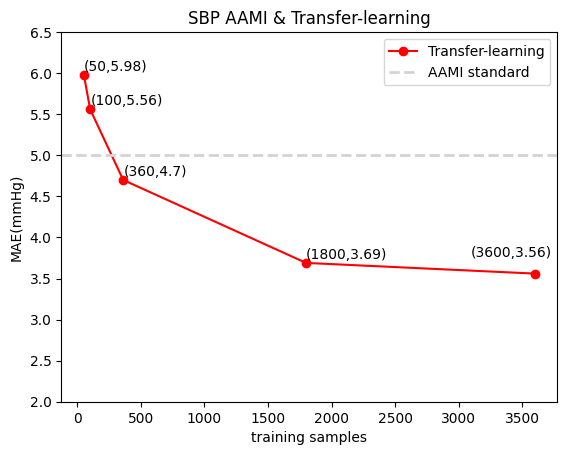

In [24]:
x_2 = [50, 100, 360, 1800, 3600]
y_2 = [5.98, 5.56, 4.7, 3.69, 3.56]

plt.plot(x_2, y_2, color='red', label = 'Transfer-learning', marker = ".",  markersize=12)
plt.axhline(5.0, color='lightgray', linestyle='--', linewidth=2, label = 'AAMI standard')
plt.ylim(2,6.5)
plt.legend()

for i in range(len(x_2)-1):
    plt.annotate('('+str(x_2[i])+','+str(y_2[i])+')', xy=(x_2[i], y_2[i]), xytext=(x_2[i]+1, y_2[i]+0.05))
plt.annotate('('+str(x_2[4])+','+str(y_2[4])+')', xy=(x_2[4], y_2[4]), xytext=(x_2[4]-500, y_2[4]+0.2))

plt.title("SBP AAMI & Transfer-learning")
plt.xlabel("training samples")
plt.ylabel("MAE(mmHg)")

Text(0, 0.5, 'MAE(mmHg)')

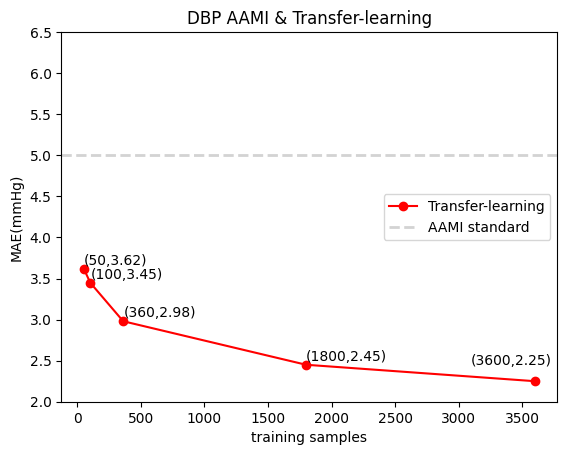

In [21]:
x_2 = [50, 100, 360, 1800, 3600]
y_2 = [3.62, 3.45, 2.98, 2.45, 2.25]

plt.plot(x_2, y_2, color='red', label = 'Transfer-learning', marker = ".",  markersize=12)
plt.axhline(5.0, color='lightgray', linestyle='--', linewidth=2, label = 'AAMI standard')
plt.legend(loc = 'right')

for i in range(len(x_2)-1):
    plt.annotate('('+str(x_2[i])+','+str(y_2[i])+')', xy=(x_2[i], y_2[i]), xytext=(x_2[i]+1, y_2[i]+0.05))
plt.annotate('('+str(x_2[4])+','+str(y_2[4])+')', xy=(x_2[4], y_2[4]), xytext=(x_2[4]-500, y_2[4]+0.2))

plt.title("DBP AAMI & Transfer-learning")
plt.ylim(2,6.5)
plt.xlabel("training samples")
plt.ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)